## Chaos Waveform Analysis

Warren Li

April 23, 2017

Sampling Rate: 44100 samples/sec
Samples: 9695232
Audio Length: 219.8465306122449 sec
Bit Transmission Rate: 0.02 sec
Samples per Bit: 882


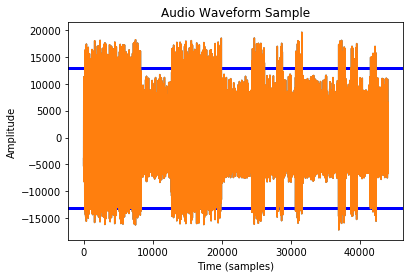

In [30]:
from scipy.io.wavfile import read
import matplotlib.pyplot as plt

bit_transmission_rate = 0.02
input_data = read("new_coded_message.wav")
audio = input_data[1]
sample_rate = input_data[0]
audio_length = len(audio)/sample_rate
samples_per_bit = int(bit_transmission_rate * sample_rate)

print("Sampling Rate:", sample_rate, "samples/sec")
print("Samples:", len(audio))
print("Audio Length:", audio_length, "sec")
print("Bit Transmission Rate:", bit_transmission_rate, "sec")
print("Samples per Bit:", samples_per_bit)

start = 242800
threshold = 13000

plt.axhline(y=threshold, color='blue', lw=3)
plt.axhline(y=-threshold, color='blue', lw=3)
plt.plot(audio[start+samples_per_bit*0:start+samples_per_bit*50:1])
plt.ylabel("Amplitude")
plt.xlabel("Time (samples)")

plt.title("Audio Waveform Sample")
plt.show()

9695232


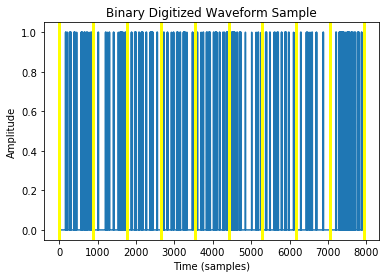

In [32]:
digitized_audio = [0 if abs(i[0]) < threshold else 1 for i in audio]
print(len(digitized_audio))

#num = 18
#manual_shift = 35350
num = 0
manual_shift= 0#24200
plt.plot(digitized_audio[manual_shift+start+samples_per_bit*9*num: manual_shift+start+samples_per_bit*9*(num+1)])

for i in range(10):
    plt.axvline(x=samples_per_bit * i, color='yellow', lw=3)

plt.ylabel("Amplitude")
plt.xlabel("Time (samples)")

plt.title("Binary Digitized Waveform Sample")
plt.show()

In [526]:
#FOR NON-ENCODED 8-bit MESSAGES
import string 

byte = ['0', '0', '0', '0', '0', '0', '0', '0']
message_bytes = []
message_ascii = []
message = []
bits = []

samples_per_bit = 900

start = True
buffer = 100
min_count = 30
idx = 0
j= 0
while idx < len(digitized_audio) - 1:

    while digitized_audio[idx] != 1:
        idx += 1
        
    for i in range(idx + samples_per_bit, idx + samples_per_bit * 9, samples_per_bit):
        bits = digitized_audio[i+buffer: i+samples_per_bit-buffer]
        if bits.count(1) > min_count:
            bit = 1
        else:
            bit = 0
        
        byte[j] = str(bit)
        j += 1

        if j % 8 == 0:
            j = 0
            idx += samples_per_bit * 10
            message_bytes.append(''.join(byte))
    
    if ''.join(byte) == '11111111' and not start:
        break
    else:
        start = False

message_ascii = [int(num, 2) for num in message_bytes]
message = [str(chr(character)) for character in message_ascii]

corrected_message = [char for char in message if char in string.printable]
print(''.join(corrected_message))

I wandered lonely as a cloud
That floats on high o'er vales and hills,
A host of golden daffodils;
Beside the lake, beneath the trees,
Fluttering and dancing in the breeze.

Continuous as the stars that shine
and twinkle on the Milky Way,
They strY@ched in never-ending line
along the margin of a bay:
Ten thousand saw I at a glance,
tossing their heads in sprightly dance.


In [7]:
import numpy.polynomial.polynomial as P

#Parameters for [n, k, d] cyclic code where dim(C) = k = n - deg g(x) = 7
#Enough to encode standard ASCII values which ranges from 0 to 2^7-1 (127)
#Minimum distance d = 5; maximum of t = floor((d-1)/2) = 2 errors can be corrected

n = 15 #Length of cyclic code
generator = [1,0,0,0,1,0,1,1,1] #g(x) = 1 + x^4 + x^6 + x^7 + x^8

def calc_syndrome(error):
    shift = P.polymul(error, [0,0,0,0,0,0,0,0,1])
    remainder = P.polydiv(shift, generator)[1]
    rem_mod_2 = [i % 2 for i in remainder]
    return rem_mod_2

error_patterns = []
for i in range(15):
    pattern = [0] * 15
    pattern[14] = 1
    pattern[i] = 1
    error_patterns.append(pattern)
        
error_lookup = {tuple(calc_syndrome(pattern)): pattern for pattern in error_patterns}

In [8]:
def meggitt_decode(received):
    codeword = received
    shift = [0] * 15

    for i in range(0, 15):
        shift[i] = 1
        syndrome = tuple(calc_syndrome(P.polymul(shift, received)))
        if syndrome in error_lookup.keys():
            if i != 0:
                shift[i] = 0
                shift[15-i] = 1
            error = P.polymul(shift, error_lookup[syndrome])
            error_mod = [i % 2 for i in P.polydiv(error, [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1])[1]]
            codeword = P.polysub(received, error_mod)
            codeword = [int(i % 2) for i in codeword]
            return codeword[0:7]
        shift[i] = 0
    
    return codeword[0:7]

In [42]:
import string 

received = ['0'] * 15
message_bin = []
message_ascii = []
message = []
bits = []

samples_per_bit = 894

start = True
buffer = 100
min_count = 30
idx = 0
j = 0
segment_len = 0

while idx < len(digitized_audio) - 1:
    segment_len += 1
    segment_len = segment_len % 2
    
    while digitized_audio[idx] != 1 and idx < len(digitized_audio) - 1:
        idx += 1

    for i in range(idx + samples_per_bit, idx + samples_per_bit * (8+segment_len), samples_per_bit):
        bits = digitized_audio[i+buffer: i+samples_per_bit-buffer]
        if bits.count(1) > min_count:
            bit = 1
        else:
            bit = 0
        
        received[j] = bit
        j += 1

        if j % 15 == 0:
            j = 0
            char_bits = meggitt_decode(received)
            char_bits_str = [str(i) for i in char_bits]
            message_bin.append(''.join(char_bits_str))
            
            if ''.join(str(c) for c in char_bits) == '1111111' and not start:
                break
            else:
                start = False
            
    idx += samples_per_bit * 10
       

message_ascii = [int(num, 2) for num in message_bin]
message = [str(chr(character)) for character in message_ascii]

corrected_message = [char for char in message if char in string.printable]
print(''.join(corrected_message))

I wandered lonely as a cloud
That floats on high o'er vales and hills,
A host of golden daffodils;
Beside the lake, beneath the trees,
Fluttering and dancing in the breeze.

Continuous as the stars that shine
and twinkle on the Milky Way,
They stretched in never-ending line
along the margin of a bay:
Ten thousand saw I at a glance,
tossing their heads in sprightly dance.


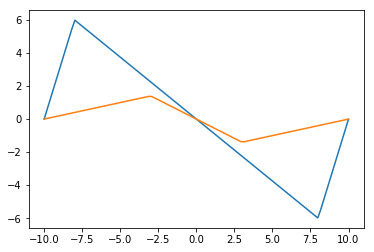

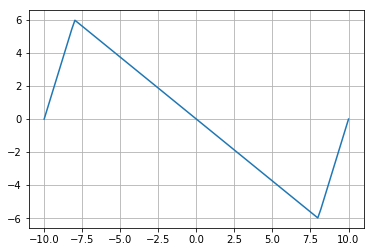